In [1]:
import netCDF4 as nc
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import collections
import xarray as xr
import statistics
import shapefile
from shapely.geometry import shape, Point
import imageio
#from IPython.display import Image
import plotly.express as px
from datetime import datetime
import random
from PIL import Image
from dateutil.relativedelta import relativedelta

plt.style.use('ggplot')

### Loading datasets (will source from other notebooks)

In [7]:
grace_df = pd.read_csv("/home/maiampow/code/csv/upsampled_grace_df.csv", parse_dates=["time"],index_col=False)
gldas_df = pd.read_csv("/home/maiampow/code/csv/dev_gldas_df.csv", parse_dates=["time"])
rese_df = pd.read_csv("/home/maiampow/code/csv/rese_dev_df.csv",parse_dates=["time"])

In [10]:
grace_df = grace_df[['time', 'lon', 'lat', 'lwe_thickness']]
gldas_df = gldas_df[['time', 'lat', 'lon', 'SWE_inst', 'SoilMoi0_10cm_inst',
       'delta_SWE_inst', 'delta_SoilMoi0_10cm_inst']]
rese_df = rese_df[['time', 'point', 'lon', 'lat', 'storage_cm',
       'storage_dev_cm', 'storage', 'storage_dev', 'name']]

In [11]:
grace_df = grace_df.drop_duplicates()
grace_df.reset_index(drop=True,inplace=True)

gldas_df = gldas_df.drop_duplicates()
gldas_df.reset_index(drop=True,inplace=True)

rese_df = rese_df.drop_duplicates()
rese_df.reset_index(drop=True,inplace=True)

## Converting to Meters

In [15]:
gldas_df["delta_SWE_inst"] = [m*0.01 for m in gldas_df["delta_SWE_inst"]]
gldas_df["delta_SoilMoi0_10cm_inst"] = [m*0.01 for m in gldas_df["delta_SoilMoi0_10cm_inst"]]

In [16]:
grace_df["lwe"] = [0.01*l for l in grace_df["lwe_thickness"]]

In [17]:
rese_df["storage_dev_m"] = [0.01*l for l in rese_df["storage_dev_cm"]]

## Combining Datasets

In [18]:
gldas_df["year_mon"] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in gldas_df["time"]]
gldas_df.reset_index(drop=True,inplace=True)

grace_df["year_mon"] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in grace_df["time"]]
grace_df.reset_index(drop=True,inplace=True)

rese_df["year_mon"] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in rese_df["time"]]
rese_df.reset_index(drop=True,inplace=True)

In [24]:
combo_df_1 = grace_df.merge(gldas_df, on=["year_mon", "lat", "lon"], how="inner")
combo_df = combo_df_1.merge(rese_df, on=["year_mon", "lat", "lon"], how="inner")

# Computing Groundwater

In [42]:
combo_df["gw_estimate"] = combo_df["lwe"] - combo_df["delta_SWE_inst"] - combo_df["delta_SoilMoi0_10cm_inst"] - combo_df["storage_dev_m"] 

In [44]:
#Averaging values over entire Colorado River Basin
groundwater_df = combo_df[['time','gw_estimate','lwe','delta_SWE_inst','delta_SoilMoi0_10cm_inst','storage_dev_m']]
groundwater_df = groundwater_df.groupby(['time']).mean().reset_index()

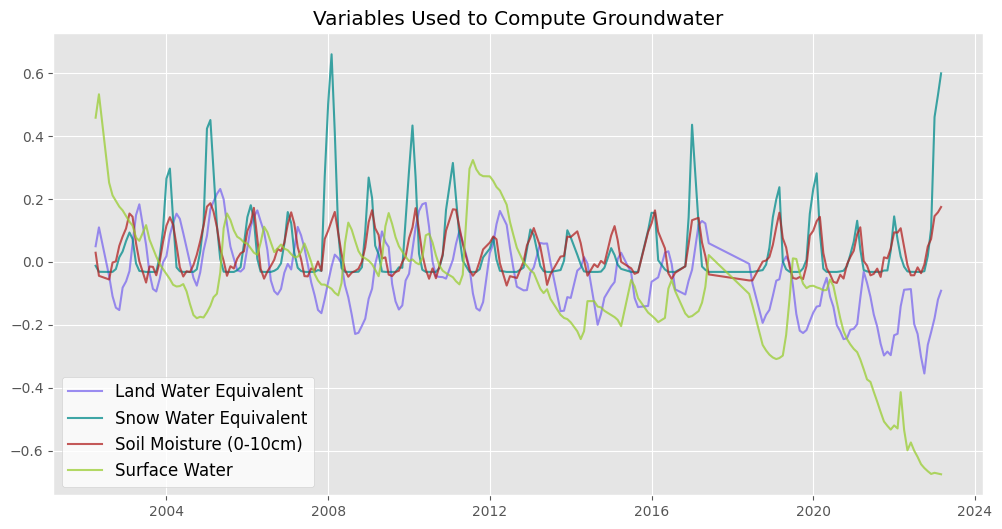

In [61]:
plt.figure(figsize=(12,6))
plt.plot(groundwater_df["time"],groundwater_df["lwe"],alpha=0.75,color="mediumslateblue")
plt.plot(groundwater_df["time"],groundwater_df["delta_SWE_inst"],alpha=0.75,color="darkcyan")
plt.plot(groundwater_df["time"],groundwater_df["delta_SoilMoi0_10cm_inst"],alpha=0.75,color="firebrick")
plt.plot(groundwater_df["time"],groundwater_df["storage_dev_m"],alpha=0.75,color="yellowgreen")
plt.title("Variables Used to Compute Groundwater")
plt.legend(["Land Water Equivalent","Snow Water Equivalent", "Soil Moisture (0-10cm)", "Surface Water"], fontsize=12,facecolor='w')
plt.show()

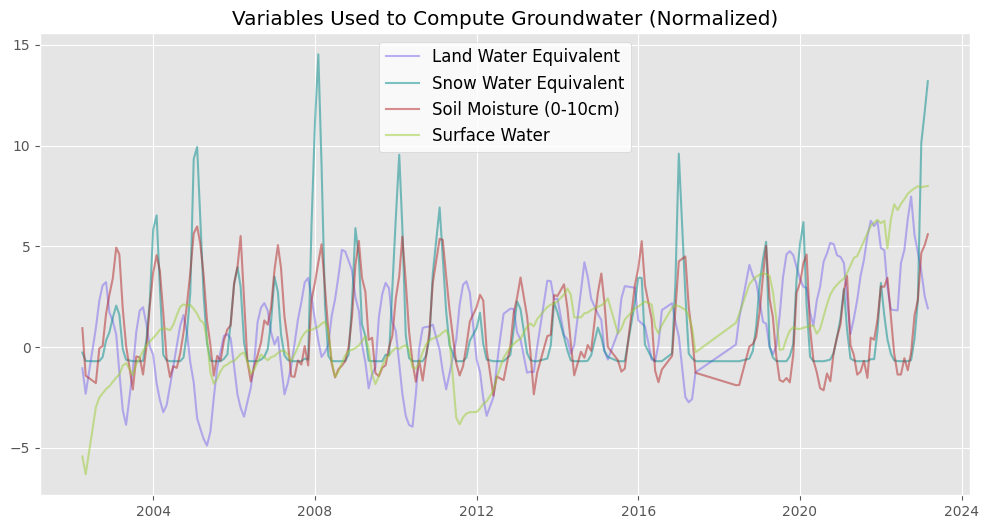

In [74]:
plt.figure(figsize=(12,6))
plt.plot(groundwater_df["time"],groundwater_df["lwe"]/statistics.mean(groundwater_df["lwe"]),alpha=0.5,color="mediumslateblue")
plt.plot(groundwater_df["time"],groundwater_df["delta_SWE_inst"]/statistics.mean(groundwater_df["delta_SWE_inst"]),alpha=0.5,color="darkcyan")
plt.plot(groundwater_df["time"],groundwater_df["delta_SoilMoi0_10cm_inst"]/statistics.mean(groundwater_df["delta_SoilMoi0_10cm_inst"]),alpha=0.5,color="firebrick")
plt.plot(groundwater_df["time"],groundwater_df["storage_dev_m"]/statistics.mean(groundwater_df["storage_dev_m"]),alpha=0.5,color="yellowgreen")
plt.title("Variables Used to Compute Groundwater (Normalized)")
plt.legend(["Land Water Equivalent","Snow Water Equivalent", "Soil Moisture (0-10cm)", "Surface Water"], fontsize=12,facecolor='w')
plt.show()

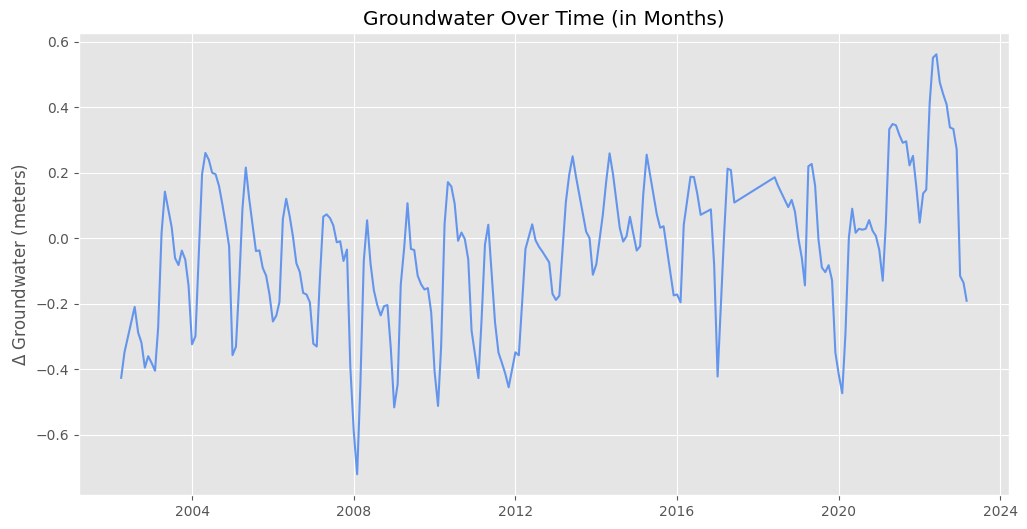

In [68]:
plt.figure(figsize=(12,6))
plt.plot(groundwater_df["time"],groundwater_df["gw_estimate"],color="cornflowerblue")
plt.title("Groundwater Over Time (in Months)")
plt.ylabel("$\Delta$ Groundwater (meters)")
plt.show()

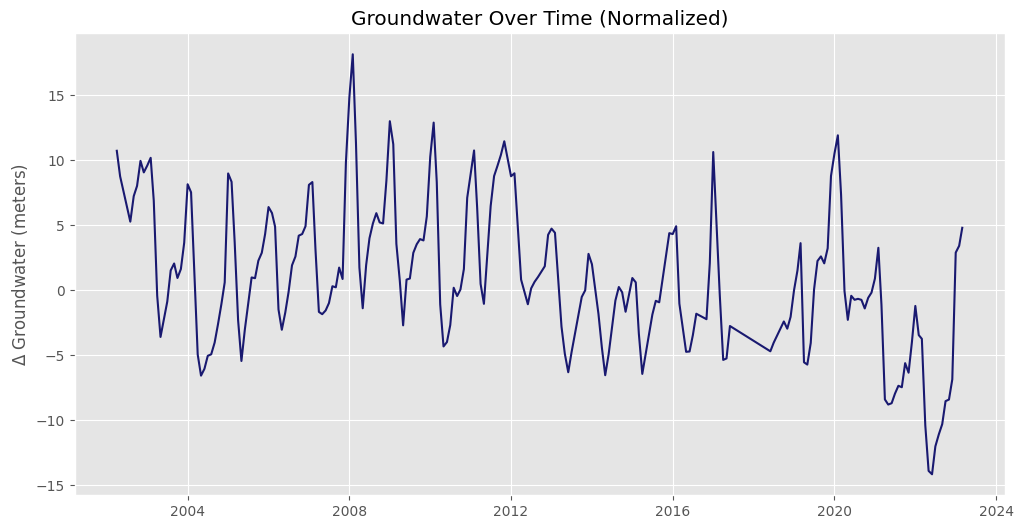

In [72]:
plt.figure(figsize=(12,6))
plt.plot(groundwater_df["time"],groundwater_df["gw_estimate"]/statistics.mean(groundwater_df["gw_estimate"]),color="midnightblue")
plt.title("Groundwater Over Time (Normalized)")
plt.ylabel("$\Delta$ Groundwater (meters)")
plt.show()